In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import pandas as pd
import ast
import glob

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.impute import KNNImputer
from sklearn import metrics
from mpl_toolkits.axes_grid1 import make_axes_locatable
from umap import UMAP
from skimage import io
from itertools import product

plt.style.use('default')
DEFAULT_COLORS = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf')
np.random.seed(105)

In [63]:
def load_data():
    """
    Load the results .csv file as pandas array
    :return: pandas dataframe
    """
    data = pd.read_csv('Result.csv', sep=';')
    return data


def patch_list_to_points(path, filter=False, structures=(1,)):
    """
    Extract all annotation lists from patchlist as a [n, 4] numpy array
    :param path: path to patchlist
    :return: numpy array
    """
    with open(path, 'r') as file:
        liste = [line.strip().split(";") for line in file]

    all_labels = []
    images = []
    coords = []
    all_structures = []
    all_ambiguous = []
    for row in liste:
        if int(row[4]) not in structures:
            continue
        all_labels.append(ast.literal_eval(row[5]))
        img_name = row[0].split("\\")[-1]
        images.append(img_name)
        coords.append([int(row[1]), int(row[2])])
        all_structures.append(int(row[4]))
        
        if len(row) > 7:
            ambiguous = ast.literal_eval(row[6])
        else:  # To consider patchlists made before the addition of the ? checkboxes
            ambiguous = np.array(ast.literal_eval(row[5])) == 0.5
            ambiguous = ambiguous.tolist()
        all_ambiguous.append(ambiguous)

    all_labels = all_labels
    coords = coords
    images = images
    all_structures = all_structures
    all_ambiguous = all_ambiguous

    if filter:
        all_labels, coords, images, all_structures = filter_points(all_labels, coords, images, all_structures)

    return all_labels, coords, images, all_structures, all_ambiguous

def filter_points(points, coords, images, structures):
    """
    Filters out any point with labels equal to 0.5
    :param points: array of shape (N, 4) of points with 4 features
    :return: filtered array
    """
    temp = points[:] == 0.5

    temp = np.sum(temp[:, :2], axis=1)

    indices = temp < 1
    out_points = points[indices, :]
    out_coords = coords[indices]
    out_images = images[indices]
    out_structures = structures[indices]

    return out_points, out_coords, out_images, out_structures

def impute_missing_labels(points, n_neighbors=5):
    """
    Use KNN to estimate missing labels
    :param point:
    :return:
    """
    imputer = KNNImputer(missing_values=np.nan, weights='distance', n_neighbors=n_neighbors)
    X = imputer.fit_transform(points)

    return X

def filter_structures_only(points, coords, images, structures):
    """
    Only keep points with strcutures == 1
    :param points:
    :param coords:
    :param images:
    :param structures:
    :return:
    """
    indices = structures == 1

    out_points = points[indices, :]
    out_coords = coords[indices]
    out_images = images[indices]
    out_structures = structures[indices]

    return out_points, out_coords, out_images, out_structures


def combine_labels(label_list, coords_list, images_list, structures_list, conditions_list, ambiguous_list):
    """
    Concatenate labels from a list of extracted patchlists
    :param label_list:
    :return: numpy array
    """
    labels = np.concatenate(label_list, axis=0).tolist()
    coords = np.concatenate(coords_list, axis=0).tolist()
    images = np.concatenate(images_list).tolist()
    structures = np.concatenate(structures_list).tolist()
    conditions = np.concatenate(conditions_list).tolist()
    ambiguous = np.concatenate(ambiguous_list).tolist()

    return labels, coords, images, structures, conditions, ambiguous


def scatter_labels(labels, legend, label_names=('Ruffles Qty', 'Ruffles Size', 'Fragmentation', 'Diffusion')):
    """
    Scatter plot of feature pairs
    :param labels:
    :param legend:
    :param label_names:
    :return:
    """
    for i in range(labels[0].shape[1]):
        for j in range(labels[0].shape[1]):
            if j <= i:
                continue
            for l, lbl in zip(labels, legend):
                #l = filter_points(l)
                x = l[:, i]
                y = l[:, j]

                plt.scatter(x, y, alpha=0.45, label=lbl)
            plt.xlabel(label_names[i])
            plt.ylabel(label_names[j])
            plt.xlim(-0.1,1.1)
            plt.ylim(-0.1,1.1)
            plt.legend()
            plt.show()

def label_clustering(features, seed=105, n_clusters=7, method='kmeans'):
    """
    Cluster labels
    :param labels_list:
    :param seed:
    :return:
    """
    if method == 'kmeans':
        knn = KMeans(n_clusters=n_clusters, random_state=seed)
    elif method == 'spectral':
        knn = SpectralClustering(n_clusters=n_clusters, random_state=seed)
    elif method == 'hierarchical':
        knn = AgglomerativeClustering(n_clusters=n_clusters)
    elif method == 'DBSCAN':
        knn = DBSCAN(eps=n_clusters)

    knn_labels = knn.fit_predict(features).astype('int').ravel()

    return features, knn_labels, knn

def load_image(image_name):
    """
    Find and load image into np array + convert into RGB for pretty pictures
    :param image_name: name of the image to load
    :return: image as RGB numpy array
    """
    image_name = image_name.translate(str.maketrans({'[':'[[]', ']':'[]]'}))  # stupidest shit ever
    image_path = glob.glob(f"images/*/*/*/{image_name}", recursive=True)
    print(image_path)
    image_path = image_path[0]
    image = io.imread(image_path).astype('float32')


    image[0] *= 255.0 / np.percentile(image[0], 99)
    image[1] *= 255.0 / np.percentile(image[1], 99)
    image = np.clip(image, 0, 255.0)
    image = (image).astype('uint8')


    image = np.array([image[0], image[1], np.zeros(image.shape[1:])])
    image = np.moveaxis(image, 0, -1).astype('uint8')
    #image = np.swapaxes(image, 0, 1).astype('uint8')
    return image


def localize_clusters(image, coords, labels, size=64, n_examples=0, im_name='', n_clusters=5, colors=DEFAULT_COLORS):
    """
    Localize the crops of each cluster in the original image
    :param image: original image
    :param coords: np array of coordinates
    :param labels: np array of classes
    :param size: Size of the crops
    :param n_examples: Number of examples of each class to extract
    :return:
    """

    ax = plt.subplot()
    ax.axis('off')
    ax.imshow(image)

    counts = [0 for _ in range(n_clusters)]
    for (y,x), c in zip(coords, labels):
        rect = patches.Rectangle((y,x), size, size, alpha=0.62, facecolor=colors[c], edgecolor='white', linewidth=0.33)
        ax.add_patch(rect)

        if np.random.random() < 0.25 and n_examples > 0:
            if counts[c] < n_examples:
                counts[c] += 1
                crop = image[x:x+size, y:y+size, 1]
                io.imsave(f'crops/class_{c}-crop_{counts[c]}_{im_name}.tif', crop)

    return ax

def umap_clusters(X, y, method='UMAP', seed=105):
    """
    Generate the UMAP visualization of the clustering
    :param X: numpy array of features
    :param y: numpy array of classes found by clustering
    :param seed: random state
    :return:
    """
    if method == 'UMAP':
        umap = UMAP(n_components=2, random_state=seed)
    elif method == 'TSNE':
        umap = TSNE(n_components=2, perplexity=30, random_state=seed)
    elif method == 'PCA':
        umap = PCA(n_components=2, random_state=seed)

    umap_data = umap.fit_transform(X)

    return umap_data

    
def plot_umap(X, y, labels=None, legend='Class', title='UMAP Visualization of K-Means Clustering', filename='umap'):
    """
    Generate the UMAP visualization of the clustering
    :param X: numpy array of features
    :param y: numpy array of classes found by clustering
    :param seed: random state
    :return:
    """
    plt.figure(figsize=(3,3), dpi=300)
    
    if labels is None:
        labels = np.unique(y)

    for l in np.unique(y):
        idx = y == l

        plt.scatter(X[idx,0], X[idx,1], alpha=0.45, label=labels[l], c=DEFAULT_COLORS[l])
        #plt.xlabel(label_names[i])
        #plt.ylabel(label_names[j])
    plt.legend(title=legend)
    plt.title(title)
    plt.savefig(f'{filename}.pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

def quantify_clusters(X, y):
    """
    Show average features of different clusters
    :param X: features
    :param y: cluster indicex
    :return:
    """
    cluster_array = []
    for l in np.unique(y):
        idx = y == l
        l_X = X[idx]

        cluster_array.append(list(np.median(l_X, axis=0)))

    cluster_array = np.array(cluster_array)

    plt.figure(figsize=(2,2), dpi=300)
    ax = plt.subplot()
    mat = ax.matshow(cluster_array, vmin=0, vmax=1)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['Class 1', 'Class 2', 'Class 3', 'Class 4'], rotation=45)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(mat, cax=cax)
    plt.savefig('codebar.pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

def classify_by_values(X):
    """
    Transform values to classes
    :param X:
    :return:
    """

    out_X = np.where(X < 0.5, 0, X)
    out_X = np.where(out_X > 0.5, 2, out_X)
    out_X = np.where(out_X == 0.5, 1, out_X)

    return out_X.astype('uint8')


def count_classes(labels):
    """
    Count the amount of each class for plottin'
    :param X:
    :return:
    """
    counts = [[], [], []]
    for c in (0,1,2):
        counts[c] = (list(np.sum(labels == c, axis=0)))

    counts = np.array(counts).T

    return np.array(counts)

def plot_bars(counts, title):
    """
    Just count how many of each class there is and do a lil bar graph
    """
    # Linear - Lots of Ruffles
    # Small ruffles - Big ruffles
    # Continuous - Fragmented
    # Sharp - Diffuse

    features = [1,2,3,4]
    classes = ['< 0.5', '= 0.5', '> 0.5']
    plt.figure(figsize=(2,2), dpi=100)

    for c in range(3):
        offset = 0.20*(c-1)
        x = np.array([1,2,3,4])+offset
        plt.bar(x,counts[:,c], width=0.20, label=classes[c], edgecolor='black', linewidth='1.0')

    plt.xticks((1,2,3,4), features)
    plt.ylabel('Number of crops')
    plt.xlabel('Class')
    plt.title(title)
    plt.legend()
    plt.savefig(f'bars_{title}.pdf', bbox_inches='tight', dpi=450)
    plt.show()
    plt.close()

def plot_feature_distribution(features, title=''):
    """
    Plot a histogram of the distribution of features' values
    :param features:
    :return:
    """

    fig, axes = plt.subplots(4,1,sharey='all' ,sharex='all')
    for f in range(features.shape[1]):
        axes[f].hist(features[:,f], bins=np.arange(0,1.06,0.05), edgecolor='black', linewidth=1.0)
        #axes[f].set_ylim(0,160)
    plt.xticks(np.arange(0,1.06,0.1))
    #plt.title(f'Class {f+1}')
    plt.xlabel('Feature value')
    plt.ylabel('Number of crops')
    #plt.show()
    plt.savefig(f'hist_features.pdf', bbox_inches='tight', dpi=450)
    axes[0].set_title(title)
    plt.show()
    plt.close()

def quantify_cluster_proportions(classes, images):
    """
    Quantify the amount of crops in each cluster for every image
    :param y: classes
    :param images: image names
    :return:
    """

    all_images = np.unique(images)
    all_classes = np.unique(classes)

    for i, img in enumerate(all_images):
        plt.figure(figsize=(2, 2), dpi=100)
        counts = np.array([0 for _ in all_classes])
        y = classes[images == img]

        for c in all_classes:
            counts[i][c] += np.sum(y == c)

        plt.bar(all_classes, counts/len(y), color=DEFAULT_COLORS, edgecolor='black', linewidth=1.0)
        plt.title(f'Image {i+1}')
        plt.ylim(0,0.5)
        plt.xlabel('Cluster')
        plt.ylabel('Proportion of crops')
        plt.xticks(all_classes, all_classes)
        #plt.show()
        plt.savefig(f'n_classes_{img}.pdf', bbox_inches='tight', dpi=450)
        plt.show()
        plt.close()
        
def quantify_cluster_proportions_cond(classes, conditions):
    """
    Quantify the amount of crops in each cluster for every condition
    :param y: classes
    :param conditions: conditions
    :return:
    """

    all_conditions = np.unique(conditions)
    all_classes = np.unique(classes)

    for i, cond in enumerate(all_conditions):
        plt.figure(figsize=(2, 2), dpi=100)
        counts = np.array([0 for _ in all_classes])
        y = classes[conditions == cond]

        for c in all_classes:
            counts[c] += np.sum(y == c)

        plt.bar(all_classes, counts/len(y), color=DEFAULT_COLORS, edgecolor='black', linewidth=1.0)
        plt.title(cond)
        plt.ylim(0,0.5)
        plt.xlabel('Cluster')
        plt.ylabel('Proportion of crops')
        plt.xticks(all_classes, all_classes)
        #plt.show()
        plt.savefig(f'n_classes_{cond}.pdf', bbox_inches='tight', dpi=450)
        plt.show()
        plt.close()
        
def quantify_cluster_proportions_images(classes, conditions, images):
    """
    Quantify the amount of crops in each cluster for every condition + stack by image!
    :param y: classes
    :param conditions: conditions
    :return:
    """

    all_conditions = np.unique(conditions)
    all_classes = np.unique(classes)
    all_images = np.unique(images)

    for i, cond in enumerate(all_conditions):
        plt.figure(figsize=(2, 2), dpi=100)
        counts_total = np.array([0 for _ in all_classes])
        y = classes[conditions == cond]
        img_cond = images[conditions == cond]
        
        for j, img in enumerate(np.unique(img_cond)):
            counts = np.array([0 for _ in all_classes])
            y_im = y[img_cond == img]
            for c in all_classes:
                counts[c] += np.sum(y_im == c)
                
            colors = []
            for col in DEFAULT_COLORS:
                colors.append(tuple(int(col[i:i+2], 16) for i in (1, 3, 5)))
            colors = np.array(colors)
            colors += 60*(j-2)
            colors = np.array(colors)/255
            colors = np.clip(colors,0,1)
            
            #edges = [(0.0, 0.0, 0.4), 
            #         (0.0, 0.4, 0.0), 
            #         (0.4, 0.0, 0.0), 
            #         (0.2, 0.0, 0.4)]
            plt.bar(all_classes, counts, color=colors, edgecolor='black', linewidth=1.0, bottom=counts_total)
            counts_total += counts
        plt.title(cond)
        #plt.ylim(0,0.5)
        plt.xlabel('Cluster')
        plt.ylabel('Number of crops')
        plt.xticks(all_classes, all_classes)
        #plt.show()
        plt.savefig(f'n_classes_{cond}.pdf', bbox_inches='tight', dpi=450)
        plt.show()
        plt.close()
        
def quantify_cluster_proportions_average(classes, conditions, images):
    """
    Quantify the amount of crops in each cluster for every condition
    :param y: classes
    :param conditions: conditions
    :param images: images
    :return:
    """

    all_conditions = np.unique(conditions)
    all_classes = np.unique(classes)
    all_images = np.unique(images)

    for i, cond in enumerate(all_conditions):
        plt.figure(figsize=(2, 2), dpi=100)
        y = classes[conditions == cond]
        imgs = images[conditions == cond]

        #counts = np.array([[0 for _ in all_classes] for _ in np.unique(imgs)])
        counts = np.zeros((len(np.unique(imgs)), len(all_classes)))
        print(counts.shape)
        for idx, im in enumerate(np.unique(imgs)):
            y_img = y[imgs == im]
            for c in all_classes:
                counts[idx, c] += np.sum(y_img == c)
        counts = counts / np.sum(counts, axis=1)[:,None]
                
        counts = np.mean(counts, axis=0)
        error = np.std(counts, axis=0)

        plt.bar(all_classes, counts, yerr=error, color=DEFAULT_COLORS, edgecolor='black', linewidth=1.0)
        plt.title(cond)
        plt.ylim(0,0.5)
        plt.xlabel('Cluster')
        plt.ylabel('Proportion of crops')
        plt.xticks(all_classes, all_classes)
        #plt.show()
        plt.savefig(f'n_classes_{cond}_avg.pdf', bbox_inches='tight', dpi=450)
        plt.show()
        plt.close()

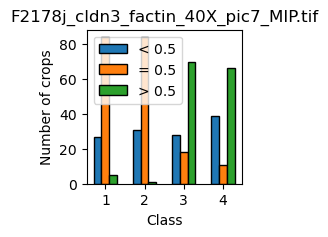

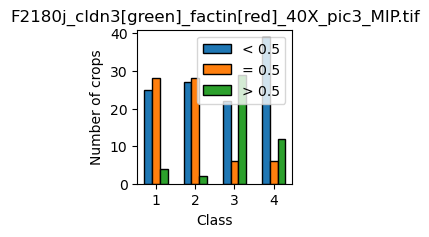

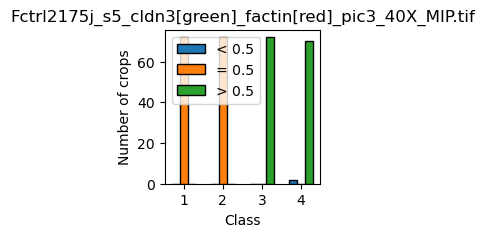

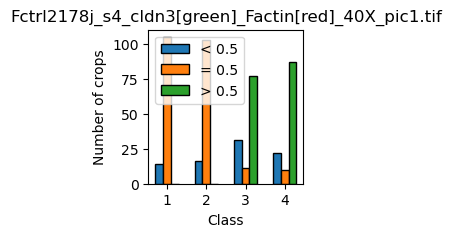

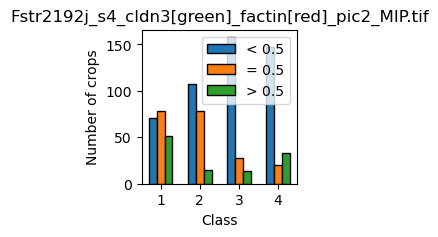

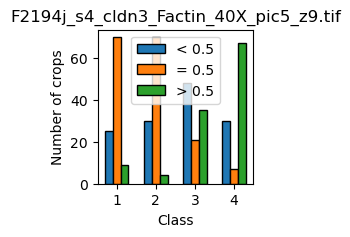

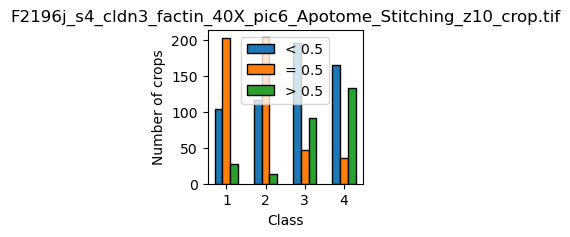

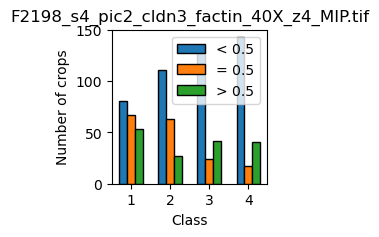

In [13]:
#paths = ('patchlist1_32.txt', 'patchlist2.txt', 'patchlist3_ancienLog_32_nouveauLog.txt', 'patchlist4.txt', 'patchlist5.txt')
condition_paths = {'Control'  : ['Image5', 'Image6', 'Image7', 'Image8'],
                   'Stressed' : ['Image1', 'Image2', 'Image3', 'Image4']}

feature_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4']

features_list, coords_list, images_list, structures_list, conditions_list, ambiguous_list = [], [], [], [], [], []


for cond in condition_paths.keys():
    for i, p in enumerate(condition_paths[cond]):
        data_path = glob.glob(f'images/{p}/*/*/patchlist*.txt')[0]
        
        features, coords, images, structures, ambiguous = patch_list_to_points(data_path, filter=False, structures=(1,))

        class_counts = count_classes(classify_by_values(np.array(features)[np.array(structures) == 1]))
        plot_bars(class_counts, images[0])

        features_list.append(features)
        coords_list.append(coords)
        images_list.append(images)
        structures_list.append(structures)
        conditions_list.append([cond for _ in range(len(images))])
        ambiguous_list.append(ambiguous)

# TODO: A nice pandas dataframe instead of this stupid thing
features, coords, images, structures, conditions, ambiguous = combine_labels(features_list, coords_list, images_list, structures_list, conditions_list, ambiguous_list)

# Impute missing/unclear labels
#features = np.array(features)
#print(features)
#print(np.array(ambiguous))
#features[ambiguous] = np.nan
#features = impute_missing_labels(features, n_neighbors=5)
#features = features.tolist()

df_dict = {'features': features,
           'coords': coords,
           'images': images,
           'structures': structures,
           'conditions': conditions,
           'ambiguous': ambiguous}

data = pd.DataFrame(df_dict)

# Filter out ambiguous
data = data[data['ambiguous'].map(np.sum) == 0]


['images\\Image5\\Image5\\TIFF input\\F2178j_cldn3_factin_40X_pic7_MIP.tif']


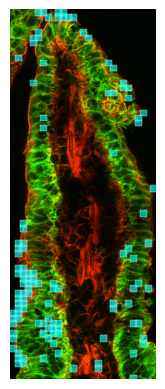

['images\\Image6\\6. Fctrl2180j_cldn3[Green]_factin[Red]_40X_pic3_MIP\\TIFF input\\F2180j_cldn3[green]_factin[red]_40X_pic3_MIP.tif']


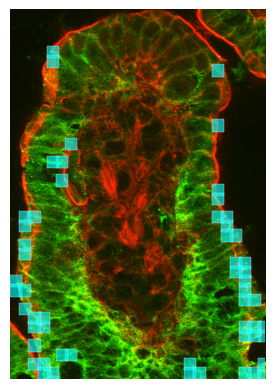

['images\\Image2\\2. F2194j_s4_cldn3_Factin_40X_pic5_Apotome_Stitching_z9\\F2194_Tiff input\\F2194j_s4_cldn3_Factin_40X_pic5_z9.tif']


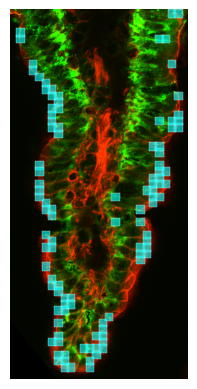

['images\\Image3\\3. F2196j_s4_cldn3_factin_40X_pic6_Apotome_Stitching_z10\\F2196j_pic6_TIFF input\\F2196j_s4_cldn3_factin_40X_pic6_Apotome_Stitching_z10_crop.tif']


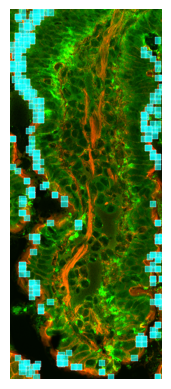

['images\\Image4\\4. F2198j_s4_cldn3_factin_40X_pic2_Apotome_Stitching_z4_MIP\\F2198_pic2 TIFF input MIP\\F2198_s4_pic2_cldn3_factin_40X_z4_MIP.tif']


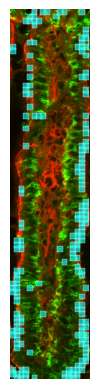

['images\\Image7\\8. Fctrl2175j_cldn3[Green]_factin[Red]_40X_pic3_MIP\\TIFF input\\Fctrl2175j_s5_cldn3[green]_factin[red]_pic3_40X_MIP.tif']


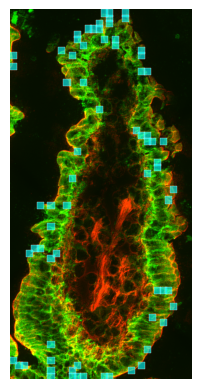

['images\\Image8\\9. Fctrl2178j_cldn3[green]_Factin[red]_40X_pic1_MIP\\Input\\Fctrl2178j_s4_cldn3[green]_Factin[red]_40X_pic1.tif']


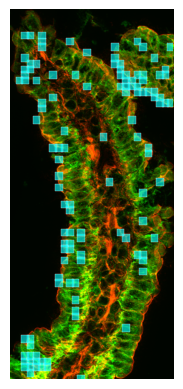

['images\\Image1\\7. Fstr2192j_cldn3[Green]_factin[Red]_40X_pic2_MIP\\Input\\Fstr2192j_s4_cldn3[green]_factin[red]_pic2_MIP.tif']


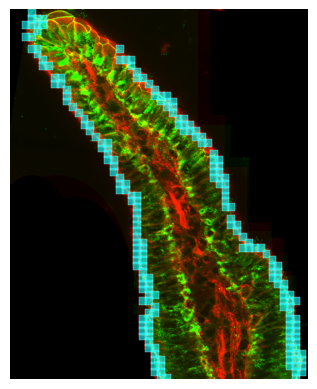

In [8]:
# Show where ambiguous vs structure
y = np.array(data['structures'].values)
for img_name in np.unique(data['images']):
    img_df = data.loc[data['images'] == img_name]
    im_y = img_df['structures'].values
    im_coords = img_df['coords'].values.tolist()

    try:
        image = load_image(img_name)
    except IndexError:
        continue
    localize_clusters(image, im_coords, im_y, colors=['black', 'cyan', 'red'])
    plt.title('')
    plt.savefig(f'structures_{img_name[:-4]}.png', bbox_inches='tight', dpi=450)
    plt.show()
    plt.close()

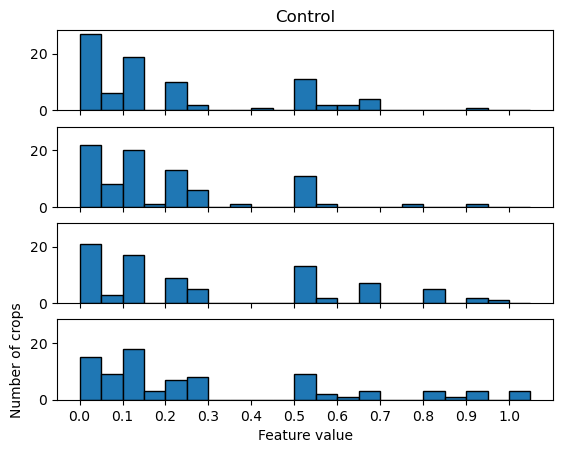

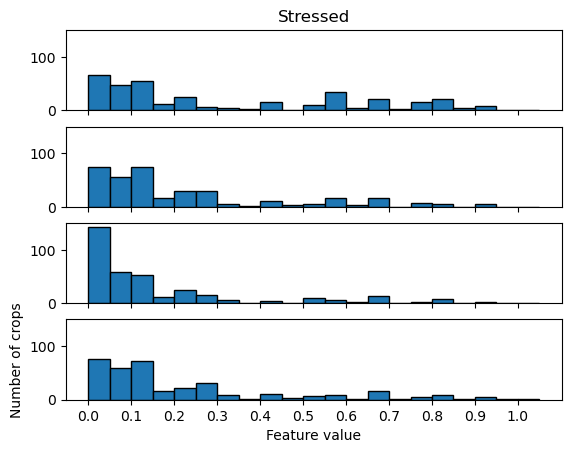

In [21]:
# Basic quantification
X = np.array(data.loc[data['conditions'] == 'Control']['features'].values.tolist())
plot_feature_distribution(X, 'Control')

X = np.array(data.loc[data['conditions'] == 'Stressed']['features'].values.tolist())
plot_feature_distribution(X, 'Stressed')

#class_X = classify_by_values(X)
#print(class_X)
#for c in range(4):
#    y = class_X[:, c]
#    for img_name in np.unique(data['images']):
#        im_y = y[images == img_name]
#        im_coords = coords[images == img_name]

#        image = load_image(img_name)
#        localize_clusters(image, im_coords, im_y)
#        plt.title(feature_names[c])
#        plt.savefig(f'{feature_names[c]}_{img_name[:-4]}.pdf', bbox_inches='tight', dpi=450)
#        plt.show()
#        plt.close()

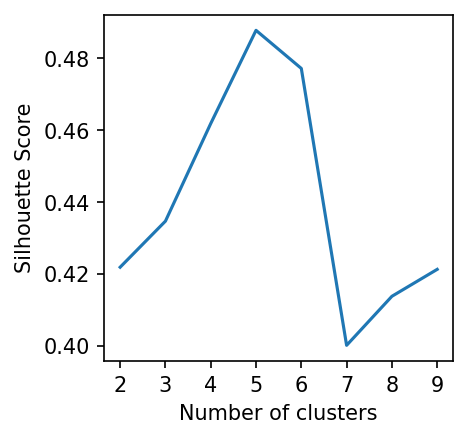

Best number of clusters:  5
Silhouette score:  0.48774521163110585


In [14]:
# Find best number of clusters using silhouette score
features = np.array(data['features'].values.tolist())
sil = []
cluster_range = np.arange(2, 10)
for n_clusters in cluster_range:
    X, y, knn_model = label_clustering(features, n_clusters=n_clusters, method='kmeans')
    sil.append(metrics.silhouette_score(X, y))

n_clusters = cluster_range[np.argmax(sil)]

plt.figure(figsize=(3,3), dpi=150)
plt.plot(cluster_range, sil)
plt.xticks(cluster_range)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

print('Best number of clusters: ', n_clusters)
print('Silhouette score: ', np.max(sil))


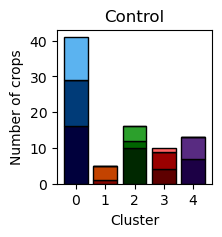

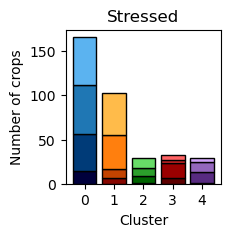

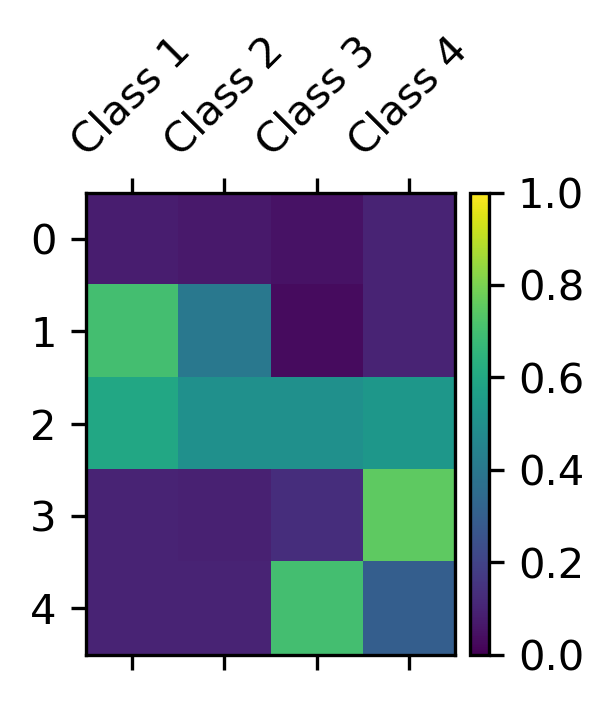

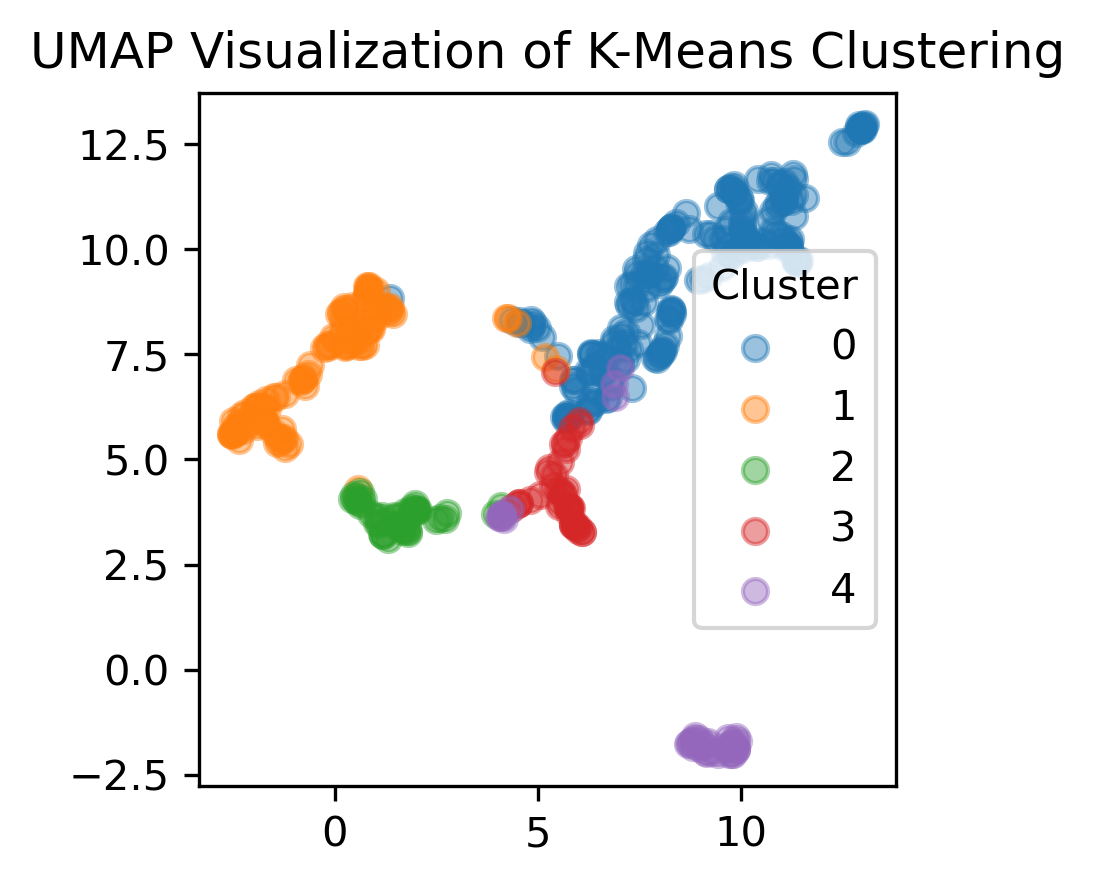

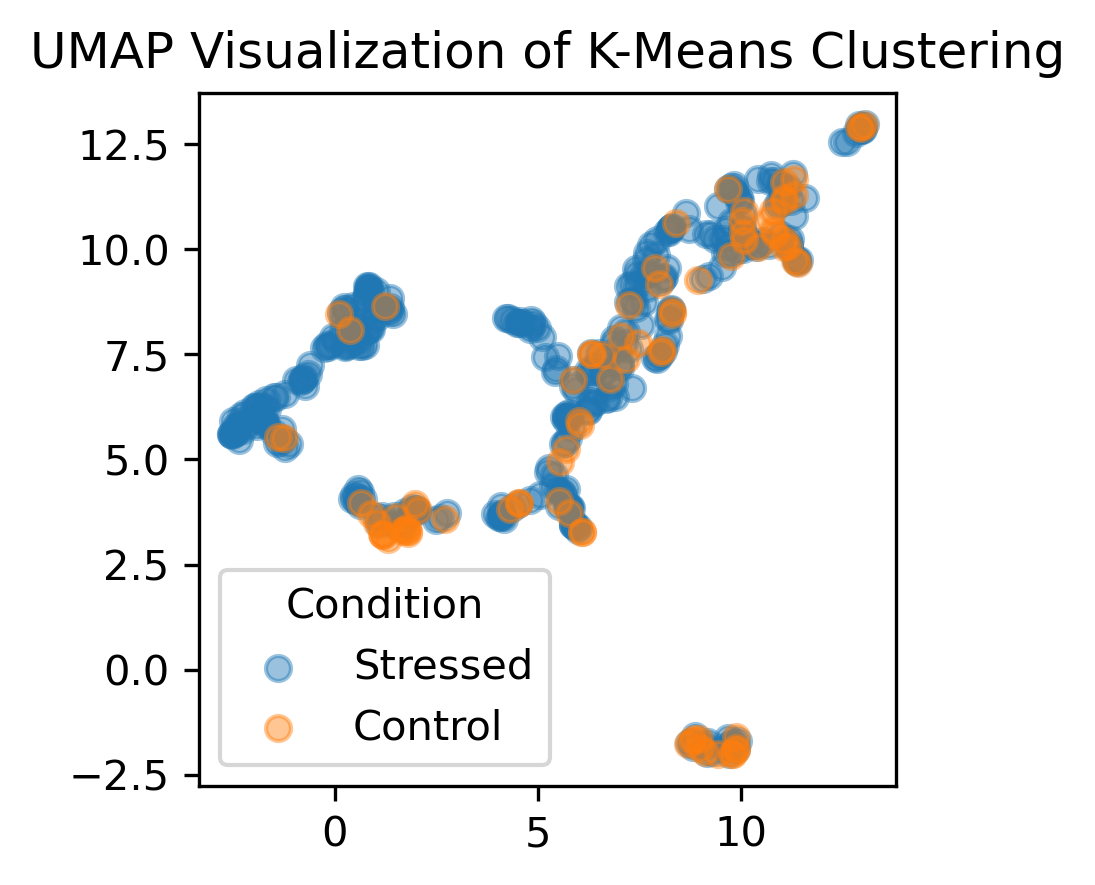

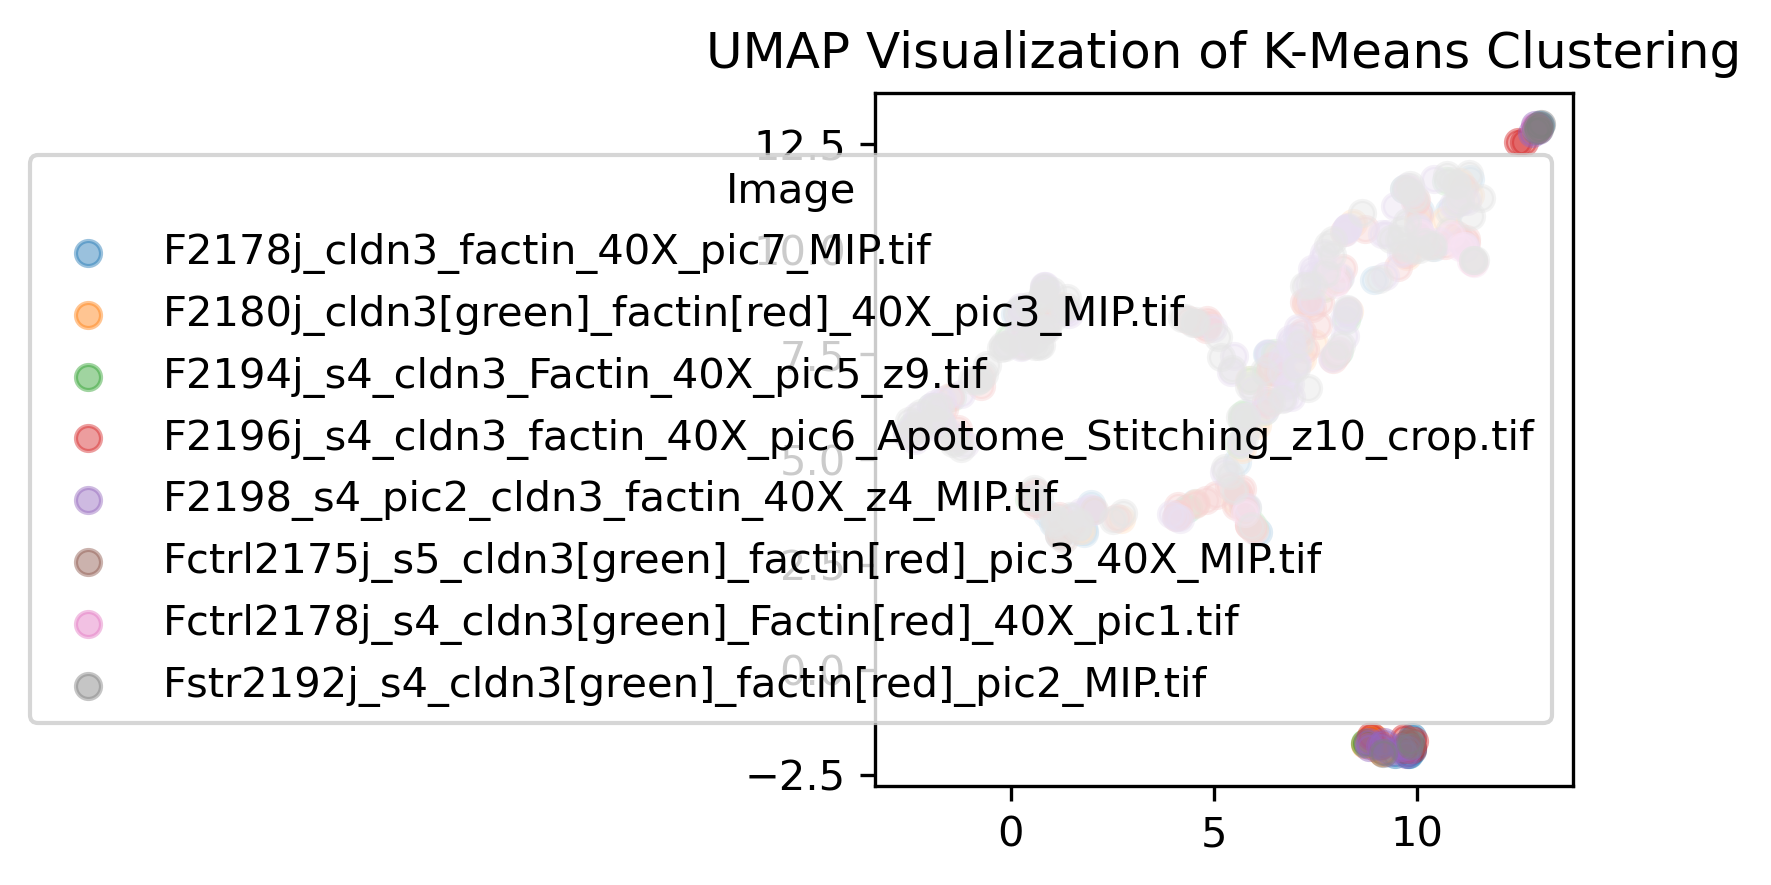

['images\\Image5\\Image5\\TIFF input\\F2178j_cldn3_factin_40X_pic7_MIP.tif']


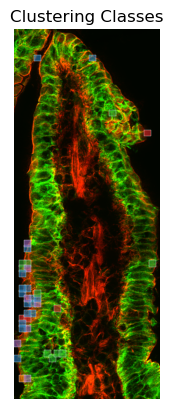

['images\\Image6\\6. Fctrl2180j_cldn3[Green]_factin[Red]_40X_pic3_MIP\\TIFF input\\F2180j_cldn3[green]_factin[red]_40X_pic3_MIP.tif']


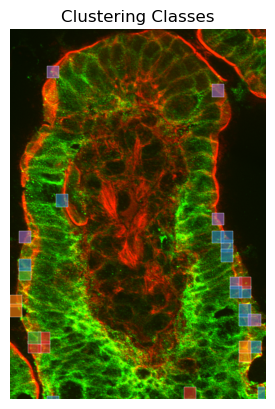

['images\\Image2\\2. F2194j_s4_cldn3_Factin_40X_pic5_Apotome_Stitching_z9\\F2194_Tiff input\\F2194j_s4_cldn3_Factin_40X_pic5_z9.tif']


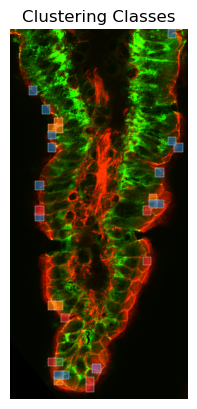

['images\\Image3\\3. F2196j_s4_cldn3_factin_40X_pic6_Apotome_Stitching_z10\\F2196j_pic6_TIFF input\\F2196j_s4_cldn3_factin_40X_pic6_Apotome_Stitching_z10_crop.tif']


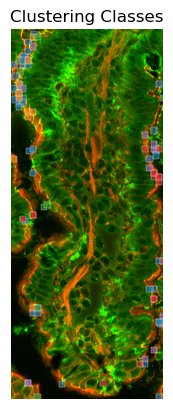

['images\\Image4\\4. F2198j_s4_cldn3_factin_40X_pic2_Apotome_Stitching_z4_MIP\\F2198_pic2 TIFF input MIP\\F2198_s4_pic2_cldn3_factin_40X_z4_MIP.tif']


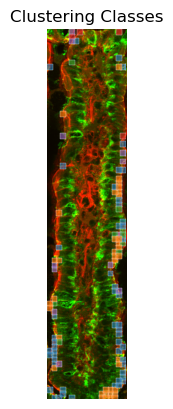

['images\\Image7\\8. Fctrl2175j_cldn3[Green]_factin[Red]_40X_pic3_MIP\\TIFF input\\Fctrl2175j_s5_cldn3[green]_factin[red]_pic3_40X_MIP.tif']


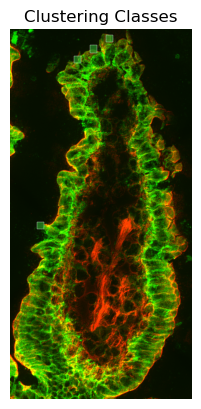

['images\\Image8\\9. Fctrl2178j_cldn3[green]_Factin[red]_40X_pic1_MIP\\Input\\Fctrl2178j_s4_cldn3[green]_Factin[red]_40X_pic1.tif']


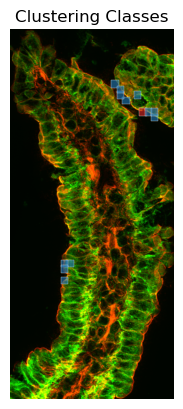

['images\\Image1\\7. Fstr2192j_cldn3[Green]_factin[Red]_40X_pic2_MIP\\Input\\Fstr2192j_s4_cldn3[green]_factin[red]_pic2_MIP.tif']


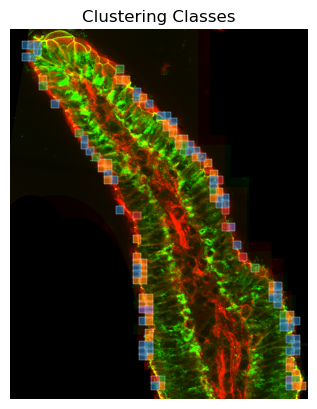

In [64]:
# Clustering
X, y, knn_model = label_clustering(features, n_clusters=n_clusters, method='kmeans')
    
#quantify_cluster_proportions_cond(y, data['conditions'])
quantify_cluster_proportions_images(y, data['conditions'], data['images'])
#quantify_cluster_proportions_average(y, data['conditions'], data['images'])
quantify_clusters(X, y)

# U-Map visualization
# Full
umap_X = umap_clusters(X, y, method='UMAP')
plot_umap(umap_X, y, legend='Cluster')

# Control vs stressed
conditions = data['conditions']
conditions = conditions.replace('Control', 1)
conditions = conditions.replace('Stressed', 0)
conditions = conditions.to_numpy()
plot_umap(umap_X, conditions, labels=['Stressed', 'Control'], legend='Condition', filename='umap_conditions')

# By image
images = data['images']
for n, i in enumerate(np.unique(images)):
    images = images.replace(i, n)
images = images.to_numpy()
plot_umap(umap_X, images, labels=np.unique(data['images']), legend='Image', filename='umap_images')

for img_name in np.unique(data['images']):
    img_df = data.loc[data['images'] == img_name]
    im_y = y[data['images'] == img_name]
    im_coords = img_df['coords'].values.tolist()

    #im_y = y[images == img_name]
    #im_coords = coords[images == img_name]

    image = load_image(img_name)
    localize_clusters(image, im_coords, im_y, n_examples=5, n_clusters=n_clusters, im_name=img_name)
    plt.title('Clustering Classes')
    plt.savefig(f'clustering_{img_name[:-4]}.pdf', bbox_inches='tight', dpi=450)
    plt.show()
    plt.close()